In [1]:
from vtk import *
from vtk.util import numpy_support as VN
import meshio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import numpy as np
import linecache
import os
import sciPyFoam.polyMesh2d as mesh2d
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'
dpi=600
fig_fmt=['svg']
# path----------
path_figures='../../../../_figures'

## 1. Read and plot mesh information

Please use command `pip install sciPyFoam` to install a usefull python package to read polyMesh and plot mesh topology.

There are 5 functions are available in `sciPyFoam.polyMesh`
1. `x, y, z, cells_rect=mesh2d.readInternal('case/VTK/case_0.vtk')`
2. `faces = readFaces(caseDir)`
3. `owners = readOwner(caseDir)`
4. `neighbours = readNeighbour(caseDir)`
5. `boundaries, index_internalFaces, name_faces = readBoundary(caseDir,nFaces)`

**Interesting and smart design! the internal face index is consecutive and from zero.**

nBoundaries: 5,  ['frontAndBack', 'top', 'right', 'bottom', 'left']
nInternalFaces: 76
nBoundaries: 5,  ['frontAndBack', 'top', 'right', 'bottom', 'left']
nInternalFaces: 76


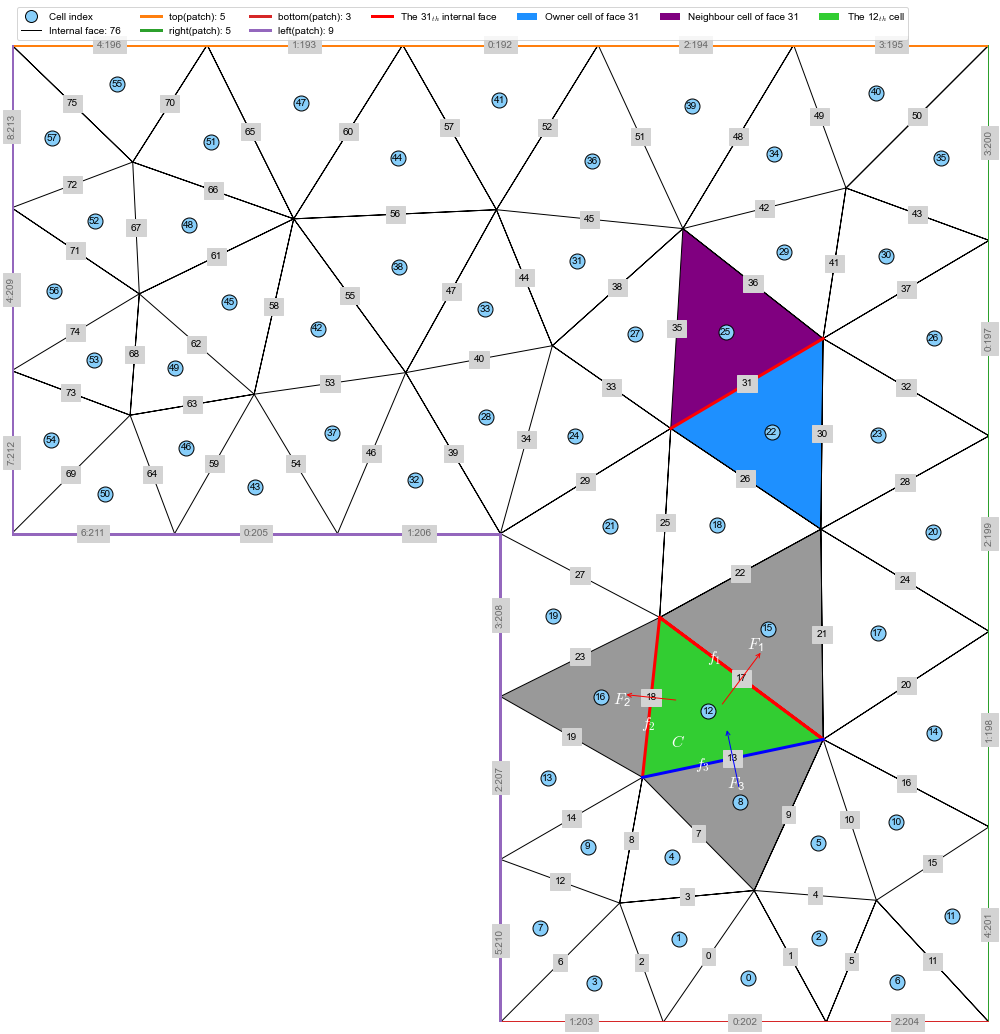

In [43]:
caseName='unstructured'
solver='test_laplacianFoam'
caseDir='../%s'%(caseName)
mesh=mesh2d.read(caseDir)
nCells=len(mesh['cells']['faces'])
index_cellC=12 
if(index_cellC>=nCells):
    index_cellC=int(nCells/2)

# plot 
figsize_mesh=(14,14)
fig=plt.figure(figsize=figsize_mesh)
ax=plt.gca()
ax.axis('scaled')
x,y,z,cells_rect,faces,boundaries,owners,neighbours=mesh2d.plotMeshTopology(ax,caseDir,ind_cell=index_cellC,index_intFace=31,lw=3)
# set axis
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.axis('off')
plt.tight_layout()
leg=ax.legend(ncol=7,loc='lower left', bbox_to_anchor=[0,1])
leg.legendHandles[0]._legmarker.set_markersize(12)
fname_fig= lambda fmt: str('%s/mesh_FVM_%s.%s'%(path_figures,caseName,fmt))
for fmt in fig_fmt:
    plt.savefig(fname_fig(fmt),dpi=dpi,bbox_inches='tight')

plt.show()

## 2. Boundary conditions

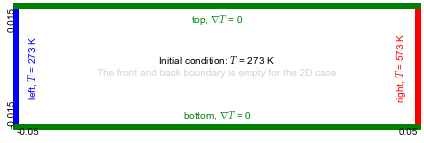

In [3]:
fig=plt.figure(figsize=(6,6))
ax=plt.gca()
bcs={'left':{'text':'$T$ = 273 K','lc':'b', 'x':[],'y':[], 'scale':[0.95,1]},
    'right':{'text':'$T$ = 573 K','lc':'r', 'x':[],'y':[], 'scale':[0.95,1]},
    'top':{'text':'$\\nabla T $ = 0','lc':'g', 'x':[],'y':[], 'scale':[1, 0.9]},
    'bottom':{'text':'$\\nabla T $ = 0','lc':'g', 'x':[],'y':[], 'scale':[1, 0.9]}}
ax.axis('scaled')
# print(faces)
for name,index in zip(boundaries['name'],boundaries['index']):
    if(name=='frontAndBack'):
        continue
    for patchIndex in index:
        x_bd,y_bd=x[faces['index'][patchIndex]], y[faces['index'][patchIndex]]
        ax.plot(x_bd,y_bd,color=bcs[name]['lc'],lw=6,clip_on=False)
        bcs[name]['x'].append(x_bd)
        bcs[name]['y'].append(y_bd)
    bcs[name]['x'],bcs[name]['y']=np.array(bcs[name]['x']),np.array(bcs[name]['y'])
    if(bcs[name]['y'].min()==bcs[name]['y'].max()):
        ax.text(bcs[name]['x'].mean()*bcs[name]['scale'][0],bcs[name]['y'].mean()*bcs[name]['scale'][1], '%s, %s'%(name,bcs[name]['text']),ha='center',va=name,color=bcs[name]['lc'])
    elif(bcs[name]['x'].min()==bcs[name]['x'].max()):
        ax.text(bcs[name]['x'].mean()*bcs[name]['scale'][0],bcs[name]['y'].mean()*bcs[name]['scale'][1], '%s, %s'%(name,bcs[name]['text']),ha=name,va='center',rotation=90,color=bcs[name]['lc'])
ax.text(0.5,0.51,'Initial condition: $T$ = 273 K',va='bottom',ha='center',transform=ax.transAxes)
ax.text(0.5,0.49,'The front and back boundary is empty for the 2D case',va='top',ha='center',color='lightgray',transform=ax.transAxes)
ax.text(0,0,'%.2f'%(x.min()),ha='left',va='top',transform=ax.transAxes)
ax.text(1,0,'%.2f'%(x.max()),ha='right',va='top',transform=ax.transAxes)
ax.text(0,0,'%.3f'%(y.min()),ha='right',va='bottom',transform=ax.transAxes,rotation=90)
ax.text(0,1,'%.3f'%(y.max()),ha='right',va='top',transform=ax.transAxes,rotation=90)
# set axis
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.xaxis.set_ticks([x.min(), x.max()])
ax.yaxis.set_ticks([y.min(), y.max()])
# ax.set_xlabel('X (mm)')
# ax.set_ylabel('Y (mm)')
ax.axis('off')
plt.tight_layout()
# leg=ax.legend(ncol=7,loc='lower left', bbox_to_anchor=[0,1])
# leg.legendHandles[0]._legmarker.set_markersize(12)
fname_fig= lambda fmt: str('%s/boundaryConditions_FVM_%s.%s'%(path_figures,caseName,fmt))
for fmt in fig_fmt:
    plt.savefig(fname_fig(fmt),dpi=dpi,bbox_inches='tight')

plt.show()

## 3. Plot coefficients matrix

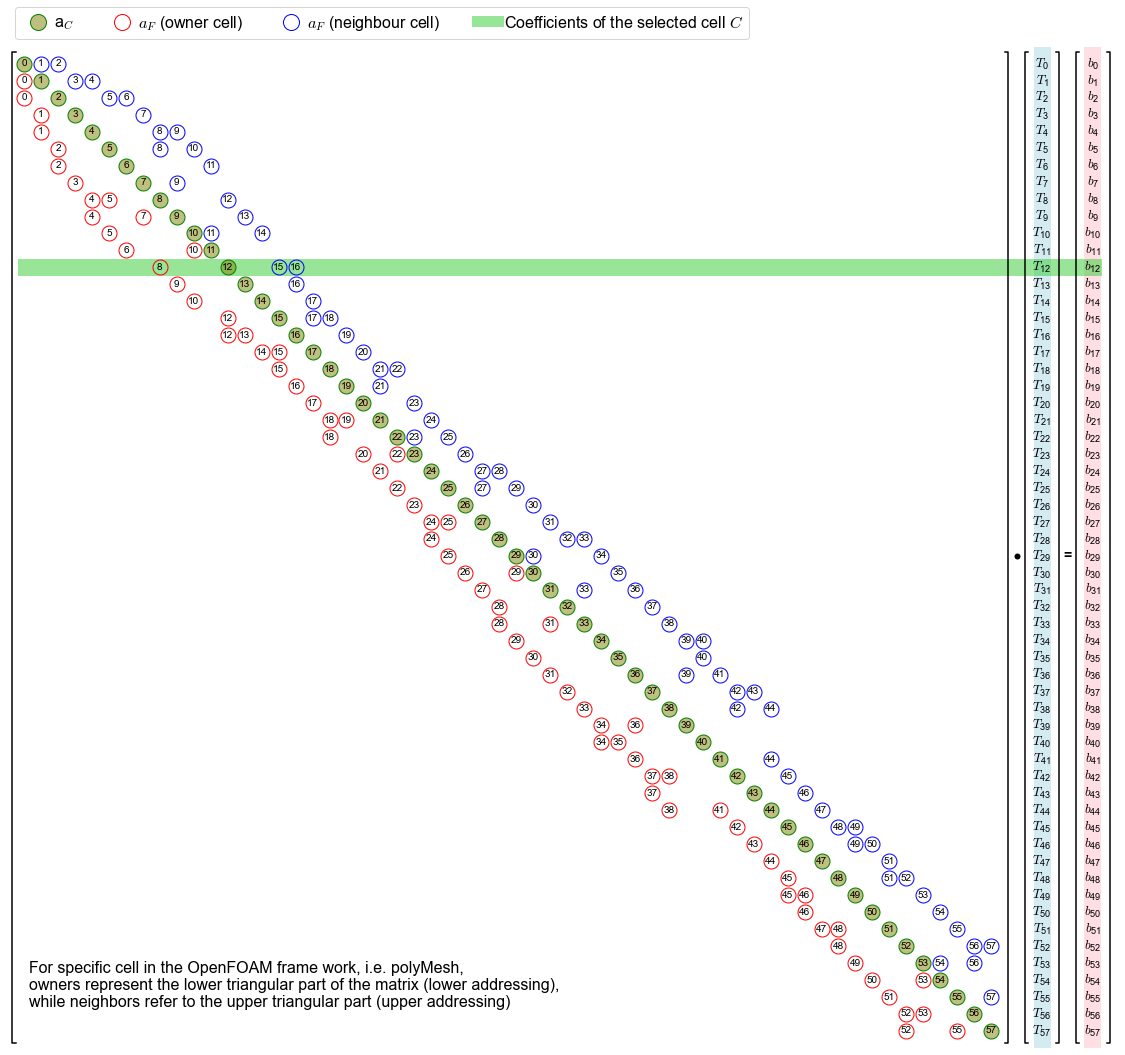

In [44]:
# plot 
figwidth=20
fig=plt.figure(figsize=(figwidth, figwidth/(nCells+5)*nCells))
ax=plt.gca()
ax.axis('scaled')
xmin,xmax=-0.5,nCells+6.5
ymin,ymax=-0.5,nCells-0.5
ax.set_xlim(xmin-0.5, xmax)
ax.set_ylim(ymin-0.5, ymax+0.5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.invert_yaxis()

# 1. plot matrix A
# ax.axvspan(xmin,xmin+nCells, fc='lightgray',alpha=0.5)
w_bracket=0.2
x_bracket, y_bracket=[xmin, xmin-w_bracket, xmin-w_bracket,xmin],[ymin-w_bracket, ymin-w_bracket, ymax+w_bracket, ymax+w_bracket]
l_brack,=ax.plot(x_bracket, y_bracket,color='k')
x0=nCells-w_bracket
x_bracket, y_bracket=[x0, x0+w_bracket, x0+w_bracket,x0],[ymin-w_bracket, ymin-w_bracket, ymax+w_bracket, ymax+w_bracket]
ax.plot(x_bracket, y_bracket,color='k')
# 2. plot vector T
x0=nCells+1.5
x_T=x0
ax.axvspan(x0, x0+1, fc='lightblue',alpha=0.5)
x0=nCells+1+w_bracket
x_bracket, y_bracket=[x0, x0-w_bracket, x0-w_bracket,x0],[ymin-w_bracket, ymin-w_bracket, ymax+w_bracket, ymax+w_bracket]
l_brack,=ax.plot(x_bracket, y_bracket,color='k')
x0=nCells+3-w_bracket
x_bracket, y_bracket=[x0, x0+w_bracket, x0+w_bracket,x0],[ymin-w_bracket, ymin-w_bracket, ymax+w_bracket, ymax+w_bracket]
ax.plot(x_bracket, y_bracket,color='k')

# 3. plot vector b
x0=nCells+4.5
x_b=x0
ax.axvspan(x0, x0+1,fc='pink',alpha=0.5)
x0=nCells+4+w_bracket
x_bracket, y_bracket=[x0, x0-w_bracket, x0-w_bracket,x0],[ymin-w_bracket, ymin-w_bracket, ymax+w_bracket, ymax+w_bracket]
l_brack,=ax.plot(x_bracket, y_bracket,color='k')
x0=nCells+6-w_bracket
x_bracket, y_bracket=[x0, x0+w_bracket, x0+w_bracket,x0],[ymin-w_bracket, ymin-w_bracket, ymax+w_bracket, ymax+w_bracket]
ax.plot(x_bracket, y_bracket,color='k')
# plot matrix value
ms=15
label_C='a$_{C}$'
label_F_owner='$a_{F}$ (owner cell)'
label_F_neigh='$a_{F}$ (neighbour cell)'
for i, owner,neighbour in zip(range(0,nCells),mesh['cells']['owner'],mesh['cells']['neighbour']):
    ax.plot(i,i,'o',ms=ms,mfc=(0.5,0.5,0,0.5),mec='g', label=label_C)
    label_C=None
    ax.text(i,i,'%d'%(i),ha='center',va='center')
    owner,neighbour=np.array(owner),np.array(neighbour)
    # woner cell
    ax.plot(owner,owner*0+i, 'o',ms=ms,mfc='None',mec='r', label=label_F_owner)
    label_F_owner=None
    for o in owner:
        ax.text(o, i, '%d'%(o), ha='center',va='center')
    # neighbour cell
    ax.plot(neighbour,neighbour*0+i, 'o',ms=ms,mfc='None',mec='b', label=label_F_neigh)
    label_F_neigh=None
    for n in neighbour:
        ax.text(n, i, '%d'%(n), ha='center',va='center')
    # T
    ax.text(x_T+0.5, i, '$T_{\mathregular{%d}}$'%(i), ha='center',va='center',fontsize=13)
    # b
    ax.text(x_b+0.5, i, '$b_{\mathregular{%d}}$'%(i), ha='center',va='center',fontsize=13)
# marker the selected cell coefficents
ax.axhspan(index_cellC-0.5, index_cellC+0.5, xmin=0.01, xmax=0.985, fc='limegreen',alpha=0.5, label='Coefficients of the selected cell $C$')

# dot
ax.plot(nCells+0.5,nCells/2.0,'o',mfc='k',mec='None')
# =
ax.text(nCells+3.5,nCells/2.0,'=',fontsize=14, fontweight='bold',va='center',ha='center')
# plot comments
comments="""
For specific cell in the OpenFOAM frame work, i.e. polyMesh,
owners represent the lower triangular part of the matrix (lower addressing),
while neighbors refer to the upper triangular part (upper addressing)
"""
ax.text(0.02, 0.02, comments, ha='left',va='bottom', transform=ax.transAxes, fontsize=16)

ax.axis('off')
# ax.grid(axis='y',which='major',lw=1, color='gray')
# ax.yaxis.set_ticklabels([])
# plt.tight_layout()
leg=ax.legend(ncol=7,loc='lower left', bbox_to_anchor=[0,1], handletextpad=0,fontsize=16)
for l in leg.legendHandles[0:3]:
    l._legmarker.set_markersize(16)
fname_fig= lambda fmt: str('%s/matrix_FVM_%s.%s'%(path_figures,caseName,fmt))
for fmt in fig_fmt:
    plt.savefig(fname_fig(fmt),dpi=dpi,bbox_inches='tight')

plt.show()

# Implementation in OpenFOAM

## 1. Plot centroids of faces

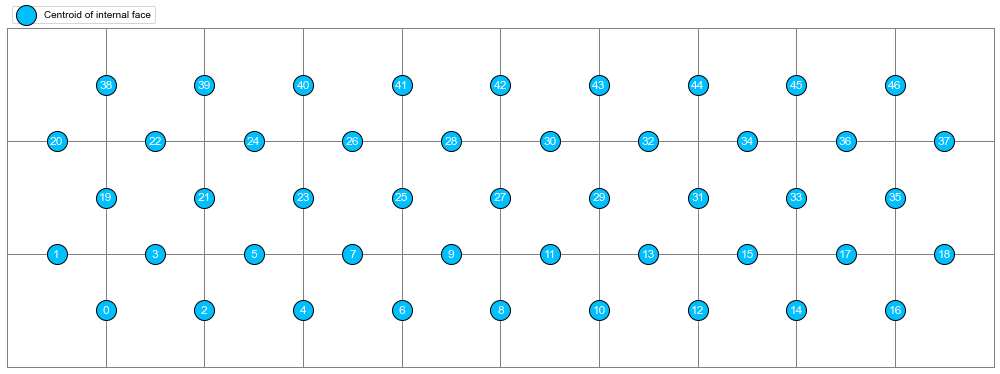

In [41]:
fig=plt.figure(figsize=figsize_mesh)
ax=plt.gca()
# 1. plot mesh
faces=mesh['faces']
for face in mesh['cells']['faces']:
    for f in face:
        if(faces['name'][f]=='frontAndBack'):
            ax.fill(x[faces['index'][f]], y[faces['index'][f]],fc='None',ec='gray',clip_on=False)
# 2. plot points
logfile='%s/log.%s'%(caseDir,solver)
alldata=linecache.getlines(logfile)
linecache.clearcache()
tag='====Cf'
start,end=0,0
for i in range(0,len(alldata)):
    alldata[i]=alldata[i].replace('\n','')
    if('===' in alldata[i]):
        if(alldata[i]==tag+' start'):
            start=i
        if(alldata[i]==tag+' end'):
            end=i
xyz=[]
for i in range(start+1, end):
    xyz.append(np.array(alldata[i].split(), dtype=float))
xyz=np.array(xyz)
xp,yp=xyz[:,0],xyz[:,1]
ax.scatter(xp,yp,marker='o', s=400,ec='k',fc='deepskyblue', label='Centroid of internal face',zorder=2)
for i in range(0,len(xp)):
    ax.text(xp[i],yp[i],'%d'%(i),va='center',ha='center',fontsize=12,zorder=3,color='w')

# set axis
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.xaxis.set_ticks([x.min(), x.max()])
ax.yaxis.set_ticks([y.min(), y.max()])
# ax.set_xlabel('X (mm)')
# ax.set_ylabel('Y (mm)')
ax.axis('off')
plt.tight_layout()
leg=ax.legend(ncol=7,loc='lower left', bbox_to_anchor=[0,1])
# leg.legendHandles[0]._legmarker.set_markersize(12)
fname_fig= lambda fmt: str('%s/Cf_%s.%s'%(path_figures,caseName,fmt))
for fmt in fig_fmt:
    plt.savefig(fname_fig(fmt),dpi=dpi,bbox_inches='tight')